# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 20.09.2022

Мягкий дедлайн: 23:59MSK 04.10.2022

Жесткий дедлайн: 23:59MSK 10.10.2022

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import random
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [2]:
# %conda install wget

In [3]:
# !wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

In [4]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


## EDA
Начнем с небольшого анализа данных. Все фичи обозначают так или иначе описывают тембр и для нас (или как минимум людей без знания теории музыки) смысла не несут.

In [5]:
((df.isna()) | (df == '')).any(axis=None)

False

> Пропущенных значений нет

In [6]:
df.groupby(by=[0])[2].count().sort_values(ascending=False)

0
2007    39404
2006    37534
2005    34952
2008    34760
2009    31038
        ...  
1925        7
1922        6
1933        6
1924        5
2011        1
Name: 2, Length: 89, dtype: int64

> Больше всего в датасете песен 2000х, 90х и 80х

<AxesSubplot: title={'center': 'Distribution of songs by the year they were written in'}, xlabel='0', ylabel='Count'>

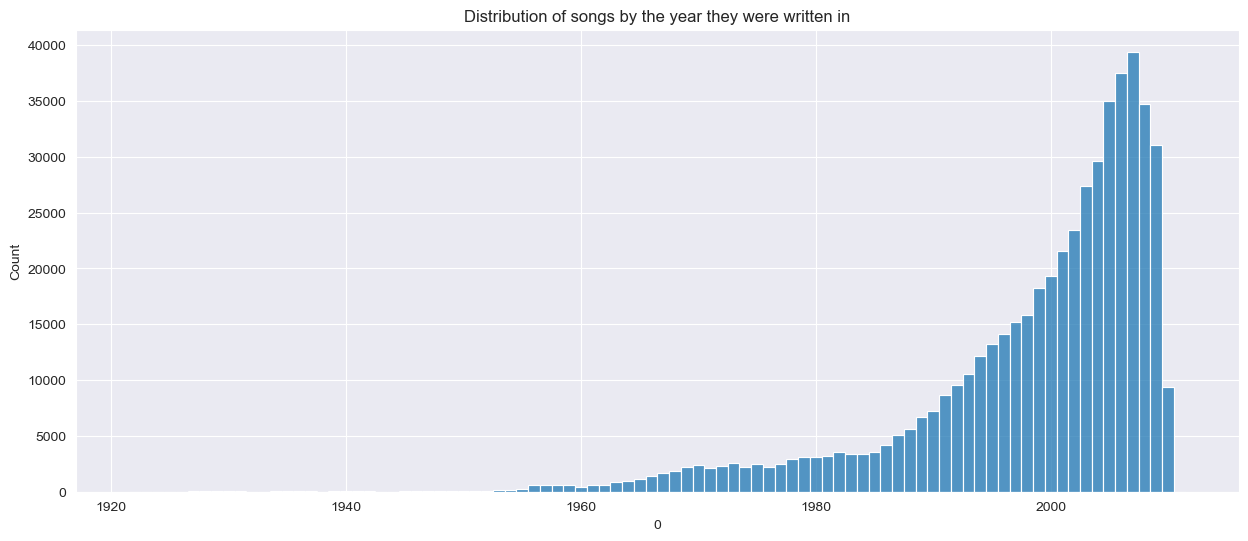

In [7]:
plt.figure(figsize=(15, 6))
plt.title("Distribution of songs by the year they were written in")
sns.histplot(df, x=df[0], discrete=True)

> Можно ожидать, что предсказания модель могут быть сильно смещены в сторону 2000-х годов

<AxesSubplot: >

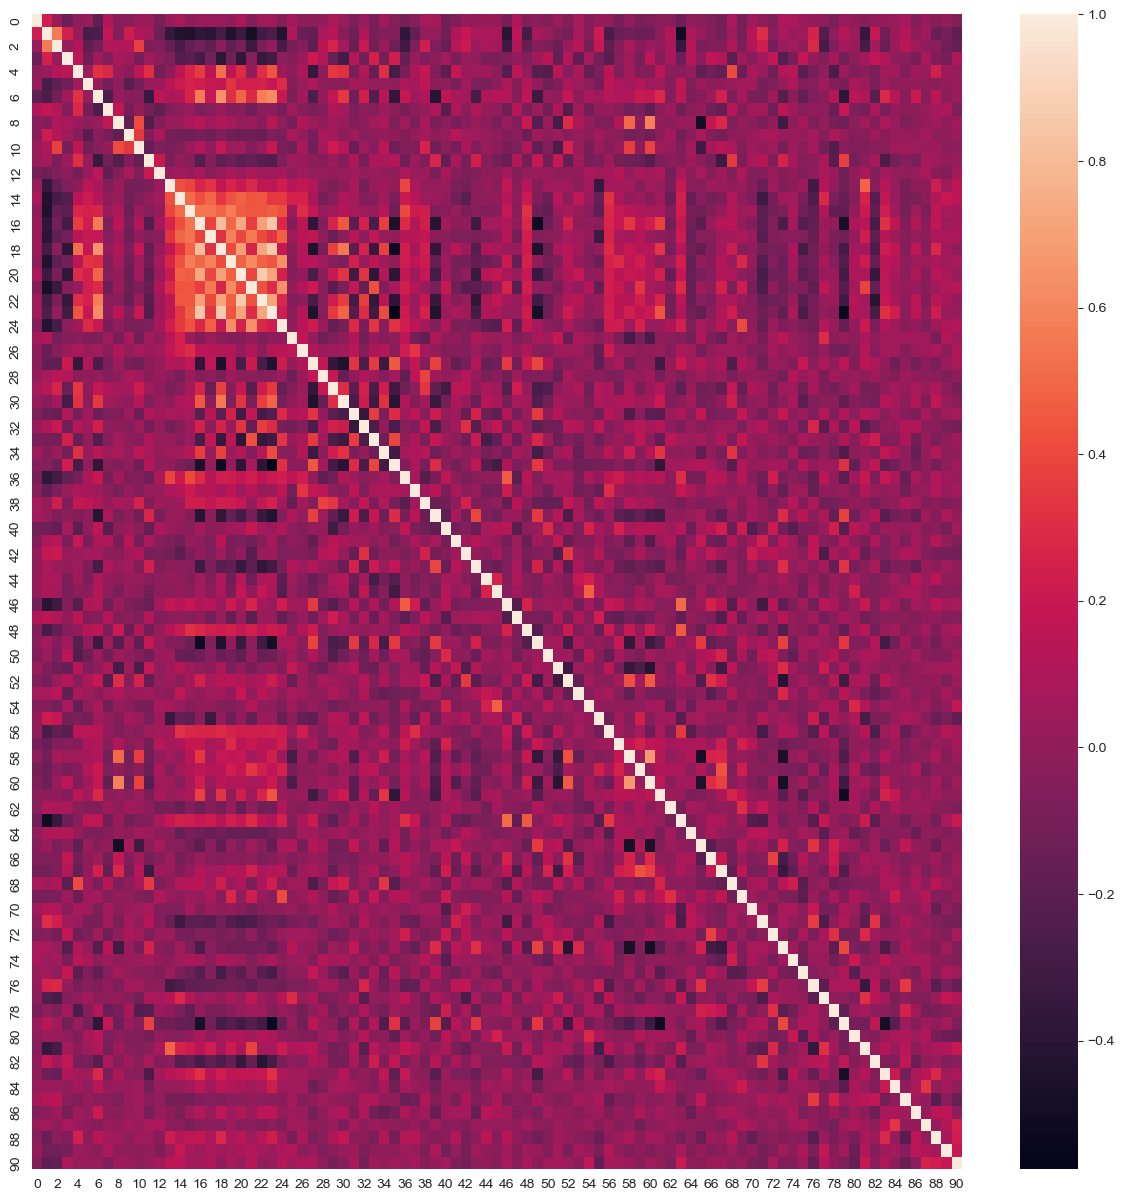

In [8]:
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr())

> С таргетом (0) ни у одной из фич корреляции нет. Можно только заметить, что у фич 12-24 есть сильная корреляция между собой. В описании датасета было указано, что 12 из 90 фич являются ковариациями тембра, так что видимо это как раз они.
>
> В целом анализ данных нам ничего особо не дал - все данные уже числовые, корреляции с таргетом не имеют и какого-то понятного нам смыслого наполнения тоже. Будем работать в слепую...

In [9]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

In [10]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error

ridgeCV_model = RidgeCV(cv=5, alphas=np.linspace(0.1, 3.5, 50) ** 2).fit(X_train, y_train)
mean_squared_error(y_test, ridgeCV_model.predict(X_test)) ** 0.5

9.510160755079452

> Чтобы не тратить время на поиск оптимального коэффициента $\alpha$ обучим Ridge при помощи RidgeCV, заодно и кросс-валидацию проведем

In [11]:
mean_squared_error(y_test, np.full_like(y_test, y_train.mean())) ** 0.5

10.863228020678134

> Математически (если я не сошел с ума) среднее значение по трейну должно давать нам наименьший лосс, а поскольку других данных для обучения у нас нет, будем считать это оптимальным константным предсказанием.

## Задание 1. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из ячейки ниже.



In [12]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.mps.deterministic = True  # mps - Metal Performance Shaders - дает возможность использовать Metal API на GPU Apple для обучения
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться следующими сигнатурами функций. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [13]:
class CustomDataset:
    def __init__(self, X, y, device="cpu"):
        self.X = torch.from_numpy(np.float32(X)).to(device)
        self.y = torch.from_numpy(np.float32(y)).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, key):
        return self.X[key], self.y[key]

> Для использования даталоадеров необходим кастомный класс датасетов, имплементирующий методы `__len__` и `__getitem__`. Вообще они дают возможность подгружать данные по необходимости (например картинки с диска), но в нашем случае это просто костыль...

> `np.float32` здесь только для из-за того, что MPS не поддерживает float64

In [14]:
from IPython.display import clear_output


def predict(model: nn.Module,
            data_loader: torch.utils.data.DataLoader,
            desc: str = "Prediction",
            target_scaler=None) -> (torch.tensor, torch.tensor):
    """
    Runs the model for given dataloader and returns both the predictions and actual targets

    :param model:           PyTorch model instance
    :param data_loader:     DataLoader instance
    :param desc:            Description to be used in tqdm
    :param target_scaler:   sklearn scaler instance, if target is scaled
    :return:                A pair of predictions and targets tensors
    """

    predictions, targets = torch.empty(0), torch.empty(0)

    with torch.no_grad():
        for b_X, b_true in tqdm(data_loader, desc=desc, leave=False):
            b_pred = model(b_X)
            predictions = torch.cat((predictions, b_pred))
            targets = torch.cat((targets, b_true))

    if target_scaler:
        predictions, targets = target_scaler.inverse_transform(predictions), target_scaler.inverse_transform(targets)
    return predictions, targets


def evaluate(model: nn.Module,
             data_loader: torch.utils.data.DataLoader,
             desc: str = "Evaluation",
             target_scaler=None) -> float:
    """
    Calculates RMSE for the given model and dataloader

    :param model:           PyTorch model instance
    :param data_loader:     DataLoader instance
    :param desc:            Description to be used in tqdm
    :param target_scaler:   sklearn scaler instance, if target is scaled
    :return:                RMSE
    """

    predictions, targets = predict(model, data_loader, desc, target_scaler)
    return mean_squared_error(targets, predictions) ** 0.5


def train(model: nn.Module,
          optimizer: torch.optim.Optimizer,
          criterion,
          train_loader: torch.utils.data.DataLoader,
          test_loader: torch.utils.data.DataLoader,
          n_epochs: int = 10,
          target_scaler=None,
          lr_scheduler=None,
          early_stopping: bool = False) -> None:
    """
    Train the model with the given configuration and plot the results

    :param model:           PyTorch model instance
    :param optimizer:       PyTorch Optimizer instance
    :param criterion:       PyTorch Loss function
    :param train_loader:    DataLoader instance for the Train dataset
    :param test_loader:     DataLoader instance for the Test dataset
    :param n_epochs:        Maximal number of epochs
    :param target_scaler:   sklearn scaler instance, if target is scaled
    :param lr_scheduler:    PyTorch Scheduler instance, if dynamic learning rate is used
    :param early_stopping:  Stop learning, once Test Loss crosses the threshold
    """

    train_loss_log, test_loss_log = [], []

    for epoch in range(1, n_epochs + 1):
        # training
        for b_X, b_true in tqdm(train_loader, desc=f"Epoch {epoch:2}\tTraining", leave=False):
            b_pred = model(b_X)
            loss = criterion(b_pred, b_true) ** 0.5
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        if lr_scheduler:
            lr_scheduler.step()

        # evaluate train
        train_loss_epoch = evaluate(model,
                                    train_loader,
                                    desc=f"Epoch {epoch:2}\tEvaluation (Train)",
                                    target_scaler=target_scaler)
        train_loss_log.append(train_loss_epoch)

        # evaluate test
        test_loss_epoch = evaluate(model,
                                   test_loader,
                                   desc=f"Epoch {epoch:2}\tEvaluation (Test)",
                                   target_scaler=target_scaler)
        test_loss_log.append(test_loss_epoch)

        # epoch results
        clear_output()
        print(f"Epoch {epoch:<10}Train\t{train_loss_epoch:.4}")
        print(f"LR    {optimizer.param_groups[0]['lr']:<10.4}Test\t{test_loss_epoch:.4}")

        # early stopping
        if early_stopping and test_loss_epoch < 8.75:
            break

    # final results
    plt.plot(np.arange(1, len(test_loss_log) + 1), train_loss_log, label="Train")
    plt.plot(np.arange(1, len(test_loss_log) + 1), test_loss_log, label="Test")
    plt.xlabel("Epoch")
    plt.ylabel("RMSE")
    plt.xticks(np.arange(0, n_epochs + 1, 5))
    plt.legend()
    plt.show()

In [15]:
from sklearn.preprocessing import StandardScaler

sc_X = StandardScaler()
X_train_norm = sc_X.fit_transform(X_train)
X_test_norm = sc_X.transform(X_test)

sc_y = StandardScaler()
y_train_norm = sc_y.fit_transform(y_train.reshape(-1, 1))
y_test_norm = sc_y.transform(y_test.reshape(-1, 1))

> Ниже приведен основной пайплайн обучения и итоговая модель.

Epoch 8         Train	8.182
LR    0.0001    Test	8.715


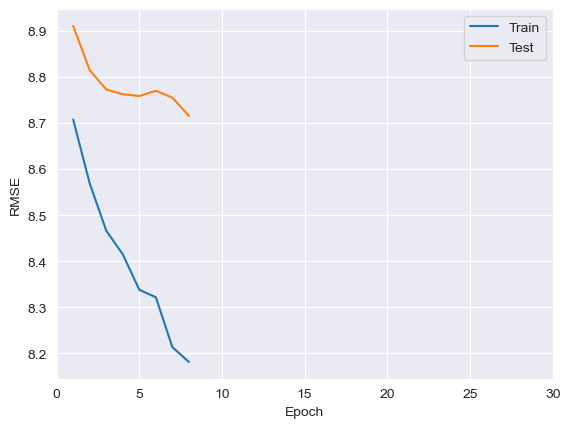

In [16]:
set_random_seed(42)
# device = "mps" if torch.backends.mps.is_available() else "cpu"  # - significantly slower in all observed cases
device = "cpu"
batch_size = 128
learning_rate = 1e-4
gamma = 1               # множитель learning_rate, используется Scheduler'ом после каждой эпохи. При 1 скорость обучения не меняется
weight_decay = 0.001
dropout_rate = 0.05
n_epochs = 30

train_set = CustomDataset(X_train_norm, y_train_norm, device=device)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_set = CustomDataset(X_test_norm, y_test_norm, device=device)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

model = nn.Sequential(
    nn.Linear(90, 512),
    nn.LeakyReLU(),

    nn.Linear(512, 512),
    nn.LeakyReLU(),

    nn.Linear(512, 512),
    nn.LeakyReLU(),

    nn.Linear(512, 1)
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
criterion = nn.MSELoss()
train(model, optimizer, criterion, train_loader, test_loader,
      n_epochs=n_epochs,
      target_scaler=sc_y,
      lr_scheduler=scheduler,
      early_stopping=True)

## Задание 2. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

### Как же так вышло
На самом деле строилась модель довольно хаотично - как правило, подбор гиперпараметров и архитектуры по одному ни к чему хорошему не приводит, так как они все очень тесно взаимосвязаны (так, например, официальная документация PyTorch рекомендует не использовать weight decay при использовании PReLU активаторов, хотя с другими активаторами он довольно полезет). Так что ниже будут скорее некоторые наблюдения, сделанные в процессе.

#### 1. Общая архитектура - количество слоев и нейронов в них
**TLDR: Больше – лучше(\*)**

Начиналось все с самой простой сетки 90 - 128 - 64 - 32 - 1. В такой конфигурации у модели слишком мало параметров, причем настолько мало, что иногда она даже не доходит до оверфиттинга. Однако работает модель невероятно быстро и качество все равно очень хорошее - местами 8.78 на тестовом датасете.

С увеличением же количества слоев и нейронов растет и количество обучаемых параметров, что дает модели больше нелинейности. В итоге лосс резко падает уже через несколько эпох - но только для тренировочного датасета, что приводит к катастрофическому оверфиттингу. Если текущую конфигурацию оставить обучаться на все 30 запланированных эпох, то получим 7.027 на тренировочном датасете и 9.1 на тестовом.

Тем не менее потенциал таких моделей все же больше - оверфиттинг можно побороть, а прирост к эффективности довольно заметный.

#### 2. Активаторы
**TLDR:  ¯\_(ツ)_/¯**

Code assistance в DataSpell и документация PyTorch открыли мне существование 13 миллиардов функций активации, у которых даже графики практически не отличаются. Тем не менее, из самой докмуентации и интернетиков удалось установить, что для задач регрессии лучше всего подходит ReLU и его производные, а для классификации сигмоида, tanh и soft<вставьте математическую функцию>. В результате были опробованы следующие функции активации:
1. ReLU - самая быстрая и простая. (Epoch 8 - Test Loss 8.724)
2. LeakyReLU - скорость примерно такая-же, однако дает чуть большую нелинйность за счет отрицательных значений. Также решает 'dying ReLU problem'. Результат выше
3. PReLU - как LeakyReLU, но открывает коэффциент $\alpha$ для обучения. Можно использовать как одно значение для всего слоя, так и свое значение для каждого нейрона. Немного медленне из-за появления нового параметра обучения. (Не опускается ниже 8.75 за 30 эпох)
4. SiLU - смесь сигмоиды и ReLU. Из-за введении операции экспоненты заметно медленнее. (Не опускается ниже 8.75 за 30 эпох)

Чем эти результаты объясняются сказать я не берусь, пусть этим займутся действительно умные люди, а я буду заниматься перебором функций))0)

#### 3. Борьба с оверфиттингом
**TLDR: Оверфиттинг можно победить, но лучше не надо**

Сначала модели в принципе не доходили до оверфиттинга - и Test Loss, и Train Loss выходили на плато и практически не изменялись. С увеличением размера модели у моделей начался очень резкий оверфиттинг - RMSE на тренировочном датасете доходило до 5-6, в то время как на тестовом поднимался до 9-10. Здесь появляются Weight Decay, Dropout, Learning Rate Scheduler и Early Stopping.

Weght Decay и Dropout оказались излишне 'инвазивными' - они хорошо предотвращают оверфиттинг, но плато, на которое выходит модель, часто оказывается слишком высоко. Особоенно все плохо с Dropout - зануляя соединения и уменьшая количество информации для обучения, он практически ни разу он не приводил к улучшению результата. Возможно это свидетельствует о какой-то более глобальной проблеме, но на это мне головного мозга не хватает.

 Динамическая скорость обучения в принципе звучит хорошо, однако в нашем случае бесполезно - модель не испытывает никаких проблем с улучшением эффективности на тренировчном датасете, поэтому замедленне обучение положительных эффектов не дает.

Наконец, Early Stopping. Хороший способ остановить модель с оверфиттингом на ее оптимальном результате. В каком-то более адекватном случае мы бы останавливались на плато, но у нас цель другая - получить RMSE <= 8.75. Остановка на плато в таком случае практически невозможна, потому что модель редко переходит указанный трешхолд и быстро начинает ухудшаться. Поэтому мы будем останавливаться как только пересечем трешхолд - пусть даже ценой гипотетически лучшей эффективности.